# 7.3 - Using built-in training and evaluation loops

* [7.3.1 - Writing your own metrics](#first-bullet)
* [7.3.2 - Using callbacks](#second-bullet)
* [7.3.3 - Writing your own callbacks](#third-bullet)
* [7.3.4 - Monitoring and visualization with TensorBoard](#fourth-bullet)

Keras offers different workflows for training and evaluating models.  Below is an example of a simple `compile()`, `fit()`, `evaluate()`, `predict()` workflow we have used before.

In [13]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.datasets import mnist
from tensorflow.keras import layers
from matplotlib import pyplot as plt

def get_mnist_model():   
    
    inputs = keras.Input(shape=(28 * 28,))
    features = layers.Dense(512, activation='relu')(inputs)
    features = layers.Dropout(0.5)(features)
    outputs = layers.Dense(10, activation='softmax')(features)
    model = keras.Model(inputs, outputs)
    return model

(images, labels), (test_images, test_labels) = mnist.load_data() 

images = images.reshape((60000, 28 * 28)).astype('float32') / 255
test_images = test_images.reshape((10000, 28 * 28)).astype('float32') / 255
train_images, val_images = images[10000:], images[:10000]
train_labels, val_labels = labels[10000:], labels[:10000]

model = get_mnist_model()
model.compile(optimizer='rmsprop',                        
              loss='sparse_categorical_crossentropy',     
              metrics=['accuracy'])                       

model.fit(train_images, train_labels,                     
          epochs=3,                                       
          validation_data=(val_images, val_labels))       

test_metrics = model.evaluate(test_images, test_labels)   

predictions = model.predict(test_images)                  


Epoch 1/3
1563/1563 [==============================] - 10s 6ms/step - loss: 0.2944 - accuracy: 0.9127 - val_loss: 0.1521 - val_accuracy: 0.9558
Epoch 2/3
1563/1563 [==============================] - 9s 6ms/step - loss: 0.1648 - accuracy: 0.9538 - val_loss: 0.1271 - val_accuracy: 0.9650
Epoch 3/3
313/313 [==============================] - 0s 1ms/step - loss: 0.1063 - accuracy: 0.9729


## 7.3.1 - Writing your own metrics <a class="anchor" id="first-bullet"></a>

We may need to create out own metrics using the `keras.metrics.Metric` class.  

A custom metric will need a definition of state variables, a way of updating the state, a way to return current metric values, and a way of resetting the current state without the need of reinstantiating the metric.

In [9]:
class RootMeanSquaredError(keras.metrics.Metric):   


    def __init__(self, name='rmse', **kwargs):    

        super(RootMeanSquaredError, self).__init__(name=name, **kwargs)
        self.mse_sum = self.add_weight(
            name='mse_sum', initializer='zeros')
        self.total_samples = self.add_weight(
            name='total_samples', initializer='zeros', dtype='int32')

    def update_state(self, y_true, y_pred, sample_weight=None):   

        y_true = tf.one_hot(y_true, depth=tf.shape(y_pred)[1])
        mse = tf.reduce_sum(tf.square(y_true - y_pred))
        self.mse_sum.assign_add(mse)
        num_samples = tf.shape(y_pred)[0]
        self.total_samples.assign_add(num_samples)
        
    def result(self):
        
        return tf.sqrt(self.mse_sum / tf.cast(self.total_samples, tf.float32))
    
    def reset_states(self):
        
        self.mse_sum.assign(0.)
        self.total_samples.assign(0)

In [10]:
model = get_mnist_model()
model.compile(optimizer='rmsprop',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy', RootMeanSquaredError()])
model.fit(train_images, train_labels,
          epochs=3,
          validation_data=(val_images, val_labels))
test_metrics = model.evaluate(test_images, test_labels)

Epoch 1/3
1563/1563 [==============================] - 9s 6ms/step - loss: 0.2903 - accuracy: 0.9141 - rmse: 7.1842 - val_loss: 0.1469 - val_accuracy: 0.9563 - val_rmse: 7.3607
Epoch 2/3
1563/1563 [==============================] - 10s 7ms/step - loss: 0.1654 - accuracy: 0.9531 - rmse: 7.3553 - val_loss: 0.1185 - val_accuracy: 0.9667 - val_rmse: 7.4031
Epoch 3/3
313/313 [==============================] - 0s 1ms/step - loss: 0.1088 - accuracy: 0.9734 - rmse: 7.4355


## 7.3.2 - Using callbacks <a class="anchor" id="second-bullet"></a>

Using callbacks can add a bit of automation to the `model.fit()` method.  Model weights can be saved, training prematurely stopped, saving checkpoints of the model state as training progresses, can all be automated using callbacks.

Some examples of `keras.callbacks` are listed below:
* `keras.callbacks.ModelCheckpoint`
* `keras.callbacks.EarlyStopping`
* `keras.callbacks.LearningRateScheduler`
* `keras.callbacks.ReduceLROnPlateau`
* `keras.callbacks.CSVLogger`

Callbacks are passed to the `model.fit()` method using the `callbacks` arguement, and any number of callbacks can be passed to this argument as a list.  Below is a list of callbacks that will stop training once accuracy stops improving for more than 1 epoch, and to save the best training result.

In [11]:
callbacks_list = [                                   
    keras.callbacks.EarlyStopping(                   
        monitor='accuracy',                          
        patience=1,                                  
    ),
    keras.callbacks.ModelCheckpoint(                 
        filepath='my_checkpoint_path',               
        monitor='val_loss',                          
        save_best_only=True,                         
    )
]

model = get_mnist_model()
model.compile(optimizer='rmsprop',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])                  

model.fit(train_images, train_labels,                
          epochs=10,                                 
          callbacks=callbacks_list,                  
          validation_data=(val_images, val_labels))  

Epoch 1/10
1557/1563 [============================>.] - ETA: 0s - loss: 0.2959 - accuracy: 0.9128WARNING:tensorflow:Callbacks method `on_test_batch_end` is slow compared to the batch time (batch time: 0.0000s vs `on_test_batch_end` time: 0.0010s). Check your callbacks.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: my_checkpoint_path\assets
1563/1563 [==============================] - 11s 7ms/step - loss: 0.2958 - accuracy: 0.9129 - val_loss: 0.1485 - val_accuracy: 0.9588
Epoch 2/10
1563/1563 [==============================] - 10s 6ms/step - loss: 0.1671 - accuracy: 0.9536 - val_loss: 0.1294 - val_accuracy: 0.9652
Epoch 3/10
1563/1563 [==============================] - 10s 6ms/step - loss: 0.1406 - accuracy: 0.9626 - val_loss: 0.1178 - val_accuracy: 0.9696
Epoch 4/10


## 7.3.3 - Writing your own callbacks <a class="anchor" id="third-bullet"></a>

You can write your own callback by subclassing the `keras.callbacks.Callback` class and implementing one of the following methods:

* `on_epoch_begin(epoch, logs)`   
* `on_epoch_end(epoch, logs)`         
* `on_batch_begin(batch, logs)`       
* `on_batch_end(batch, logs)`         
* `on_train_begin(logs)`              
* `on_train_end(logs)`                

The following example is a custom callback that saves the per-batch loss values during training and saves a graph of these values at the end of each epoch.

In [14]:
class LossHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs):
        self.per_batch_losses = []

    def on_batch_end(self, batch, logs):
        self.per_batch_losses.append(logs.get("loss"))

    def on_epoch_end(self, epoch, logs):
        plt.clf()
        plt.plot(range(len(self.per_batch_losses)), self.per_batch_losses,
                 label='Training loss for each batch')
        plt.xlabel('Batch (epoch %d)' % (epoch,))
        plt.ylabel('Loss')
        plt.legend()
        plt.savefig('plot_at_epoch_%d' % (epoch,))
        self.per_batch_losses = []

Now we can try our new custom callback in our model.

Epoch 1/10
1563/1563 [==============================] - 10s 6ms/step - loss: 0.2887 - accuracy: 0.9144 - val_loss: 0.1526 - val_accuracy: 0.9562
Epoch 2/10
1563/1563 [==============================] - 9s 6ms/step - loss: 0.1653 - accuracy: 0.9541 - val_loss: 0.1291 - val_accuracy: 0.9667
Epoch 3/10
1563/1563 [==============================] - 10s 6ms/step - loss: 0.1385 - accuracy: 0.9630 - val_loss: 0.1198 - val_accuracy: 0.9701
Epoch 4/10
1563/1563 [==============================] - 10s 7ms/step - loss: 0.1255 - accuracy: 0.9678 - val_loss: 0.1133 - val_accuracy: 0.9716
Epoch 5/10
1563/1563 [==============================] - 10s 6ms/step - loss: 0.1204 - accuracy: 0.9704 - val_loss: 0.1128 - val_accuracy: 0.9749
Epoch 6/10
1563/1563 [==============================] - 11s 7ms/step - loss: 0.1101 - accuracy: 0.9727 - val_loss: 0.1083 - val_accuracy: 0.9756
Epoch 7/10
1563/1563 [==============================] - 10s 6ms/step - loss: 0.1059 - accuracy: 0.9746 - val_loss: 0.1155 - val_acc

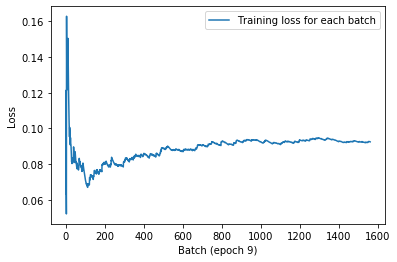

In [15]:
model = get_mnist_model()
model.compile(optimizer='rmsprop',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
model.fit(train_images, train_labels,
          epochs=10,
          callbacks=[LossHistory()],
          validation_data=(val_images, val_labels))

## 7.3.4 - Monitoring and visualization with TensorBoard <a class="anchor" id="fourth-bullet"></a>

TensorBoard is a browser-based application that can be run locally and be used to monitor a model during training.

A simple way of using TensorBoard is defining where you would like to save logs in the `keras.callbacks.TensorBoard` callback.

In [17]:
model = get_mnist_model()
model.compile(optimizer='rmsprop',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

tensorboard = keras.callbacks.TensorBoard(
    log_dir='/full_path_to_your_logs',
)
model.fit(train_images, train_labels, epochs=10, validation_data=(val_images, val_labels),
          callbacks=[tensorboard])

Epoch 1/10
   1/1563 [..............................] - ETA: 1s - loss: 2.4691 - accuracy: 0.0938WARNING:tensorflow:From c:\users\mreader\appdata\local\programs\python\python38\lib\site-packages\tensorflow\python\ops\summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
1563/1563 [==============================] - 11s 7ms/step - loss: 0.2941 - accuracy: 0.9127 - val_loss: 0.1427 - val_accuracy: 0.9585
Epoch 2/10
1563/1563 [==============================] - 12s 8ms/step - loss: 0.1655 - accuracy: 0.9532 - val_loss: 0.1169 - val_accuracy: 0.9673
Epoch 3/10
1563/1563 [==============================] - 10s 6ms/step - loss: 0.1387 - accuracy: 0.9621 - val_loss: 0.1091 - val_accuracy: 0.9704
Epoch 4/10
1563/1563 [==============================] - 10s 6ms/step - loss: 0.1236 - accuracy: 0.9682 - val_loss: 0.1120 - val_accuracy: 0.9726
Epoch 5/10
1563/1563 

In [18]:
%load_ext tensorboard
%tensorboard --logdir /full_path_to_your_logs

ERROR: Timed out waiting for TensorBoard to start. It may still be running as pid 14904.